# Description

In [1]:
#1 get GC content from contigs
    #get GC content in set chunk sizes
    
#2 get coverage for contigs
    #get coverage in chunk sizes

#3 blob plot gc vs average coverage

#4 plot gc content/coverage for each contig (if significant in some way)

#5 kmeans clusters

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
import os
import shutil

# Parameters

In [51]:
assembly = "./data/final.p_ctg_test.fasta"
coverage_per_contig = "./data/heliopora_coerulea_hifi_2_p_assembly.coverage"
coverage_per_base = "./data/heliopora_coerulea_hifi_2_p_assembly_testfile.depth"
out_dir = "out_dir/"
chunk_size = 10000
visualizeGC = True
save_GC_plot = True
visualizeCoverage = True

# Naive GC content for each content

In [4]:
def get_gc_content(fasta_file):
    """
    Reads in a FASTA file and returns a dictionary mapping contig IDs to their GC content
    """
    gc_content = {}
    current_id = None
    current_seq = ""
    
    with open(fasta_file, "r") as f:
        for line in f:
            if line.startswith(">"):
                # If this is a new contig, calculate the GC content for the previous one (if there was one)
                if current_id is not None:
                    gc_content[current_id] = (current_seq.count("G") + current_seq.count("C")) / len(current_seq)
                
                # Start the new contig
                current_id = line.strip()[1:]
                current_seq = ""
            else:
                current_seq += line.strip()
    
    # Calculate GC content for the final contig
    gc_content[current_id] = (current_seq.count("G") + current_seq.count("C")) / len(current_seq)
    
    return gc_content

In [5]:
naive_gc = get_gc_content(assembly)
print(naive_gc)

{'ctg/p/l/000409/0': 0.4361125376490347, 'ctg/p/l/000412/0': 0.3682002202177709}


# GC content for each contig by averaging in given chunk sizes

In [6]:
def get_gc_content_chunks(fasta_file, chunk_size):
    """
    Reads in a FASTA file and returns a dictionary mapping contig IDs to a list of gc content per chunk size
    """
    gc_content = {}
    current_id = None
    current_seq = ""
    chunks = []
    
    with open(fasta_file, "r") as f:
        for line in f:
            if line.startswith(">"):
                # If this is a new contig, calculate the GC content for the previous one (if there was one)
                if current_id is not None:
                    i = 0
                    while i < len(current_seq):
                        # check for last chunk
                        if (i + chunk_size) > len(current_seq):
                            end = len(current_seq)
                        else:
                            end = i + chunk_size
                        sub = current_seq[i:end]
                        gc = round(((sub.count("G") + sub.count("C")) / len(sub)),2)
                        chunks.append(gc)
                        i = end
                    # add to dictionary in form {current_id : [array of GC content of given chunk size]}
                    gc_content[current_id] = chunks
                
                # Start the new contig
                current_id = line.strip()[1:]
                current_seq = ""
                chunks = []
                
            else:
                current_seq += line.strip()
                
        # calculate GC content for the last contig
        if current_id is not None:
            i = 0
            while i < len(current_seq):
                # check for last chunk
                if (i + chunk_size) > len(current_seq):
                    end = len(current_seq)
                else:
                    end = i + chunk_size
                sub = current_seq[i:end]
                gc = round(((sub.count("G") + sub.count("C")) / len(sub)), 2)
                chunks.append(gc)
                i = end
            # add to dictionary in form {current_id : [array of GC content of given chunk size]}
            gc_content[current_id] = chunks
        
    return gc_content


In [7]:
chunks = get_gc_content_chunks(assembly, chunk_size)
#print(chunks)

# Visualize GC content 

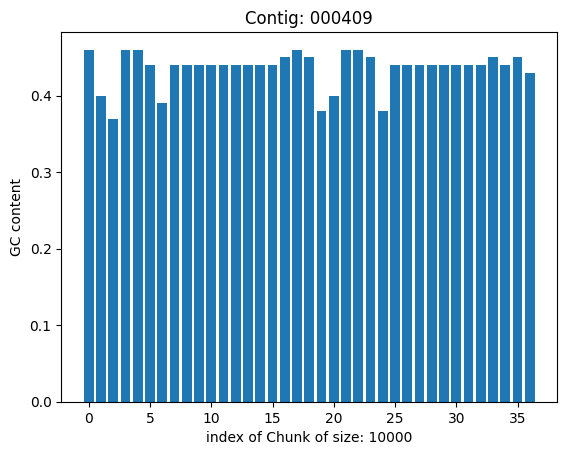

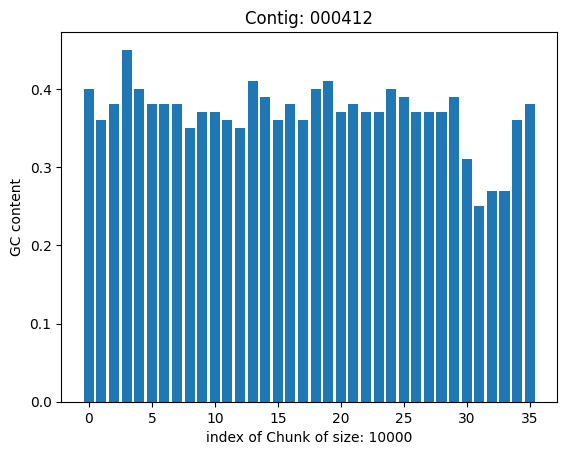

In [53]:
if save_GC_plot:
    save_dir = out_dir + "./GC_visual_output"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

if visualizeGC:
    for id, gc_content in chunks.items():
        #format id
        id = id.split("/")[3]
        
        # create a bar plot
        plt.bar(range(len(gc_content)), gc_content)
        plt.title("Contig: " + str(id))
        plt.xlabel('index of Chunk of size: ' + str(chunk_size))
        plt.ylabel('GC content')

        # save the plot
        if save_GC_plot:
            save_path = os.path.join(save_dir, "GC_content_" + str(id) + ".png")
            plt.savefig(save_path)

        # show the plot
        plt.show()

else :
    print("GC visualization is turned off.")


# Naive coverage

In [9]:
def get_coverage_per_contig(coverage_file):
    naive_coverage = {}

    with open(coverage_file, "r") as f:
        next(f)
        for line in f:
            # Split line into columns
            columns = line.strip().split("\t")

            # Use the first column as key and the sixth column as value
            key = columns[0].split("/")[3]
            value = columns[5]

            # Add key-value pair to dictionary
            naive_coverage[key] = value
            
    f.close()
    return naive_coverage

In [48]:
naive_coverage = get_coverage_per_contig(coverage_per_contig)
#print(naive_coverage)

# Chunk averaged Coverage

In [62]:
def get_coverage_per_contig_by_chunks(depth_file, chunk_size):
    save_dir = out_dir + "Coverage_output/"
    
    # Define a dictionary to store the coverage data for each ID
    id_data = {}

    # Read in the TSV file
    with open(depth_file, 'r') as tsvfile:
        reader = csv.reader(tsvfile, delimiter='\t')

        # Iterate over each row in the file
        for row in reader:
            # Extract the ID, index, and coverage from the row
            id = row[0].split("/")[3]
            index = int(row[1])
            coverage = float(row[2])

            # Check if this is the first row for this ID
            if id not in id_data:
                id_data[id] = []

            # Find the window index for this row
            window_index = index // chunk_size

            # Check if there is already coverage data for this window
            if len(id_data[id]) <= window_index:
                # Add a new entry for this window
                id_data[id].append({'window_sum': coverage, 'window_count': 1})
            else:
                # Add the coverage to the existing window data
                id_data[id][window_index]['window_sum'] += coverage
                id_data[id][window_index]['window_count'] += 1

    # Write the output to a file
    with open(save_dir + "chunked_windows_coverage.tsv", 'w') as outfile:
        for id, windows in id_data.items():
            for i, window in enumerate(windows):
                if window['window_count'] > 0:
                    avg_coverage = round((window['window_sum'] / window['window_count']), 2)
                    outfile.write(f"{id}\t{i}\t{avg_coverage}\n")
    outfile.close()
    
    #now get the average coverage for each id
        
    # Open the input file
    with open(save_dir + "chunked_windows_coverage.tsv", "r") as f:
        # Create a dictionary to store the total coverage and highest index for each id
        id_coverage = {}
        # Read through each line in the file
        for line in f:
            # Split the line into three columns
            id, index, coverage = line.strip().split("\t")
            # Convert the coverage to float
            index = float(index)
            coverage = float(coverage)
            # If the id is not in the dictionary yet, add it with a coverage of 0 and index of -1
            if id not in id_coverage:
                id_coverage[id] = {"coverage": 0, "max_index": -1}
            # Add the coverage to the total for this id
            id_coverage[id]["coverage"] += coverage
            # Update the max index for this id if the current index is higher
            if index > id_coverage[id]["max_index"]:
                id_coverage[id]["max_index"] = index
    f.close()

    # Open the output file
    with open(save_dir + "chunked_coverage.tsv", "w") as f:
        # Write the header row
        f.write("id\taverage_coverage\n")
        # Loop through the ids in the dictionary
        for id in id_coverage:
            # Get the total coverage and highest index for this id
            total_coverage = id_coverage[id]["coverage"]
            max_index = id_coverage[id]["max_index"]
            # Calculate the average coverage for this id
            average_coverage = round((total_coverage / max_index),2)
            # Write the id and average coverage to the output file
            f.write("{}\t{}\n".format(id, average_coverage))
    f.close()

    return id_data

In [63]:
chunks_coverage = get_coverage_per_contig_by_chunks(coverage_per_base, chunk_size)
#print(chunks_coverage)

# Visualize Coverage